In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from lorenz_gan.submodels import SubModelGAN, AR1RandomUpdater
from lorenz_gan.gan import normalize_data, unnormalize_data
import pandas as pd
from os.path import join, exists
import pickle
import keras.backend as K
from keras.constraints import Constraint
from keras.initializers import VarianceScaling, RandomUniform, Initializer
from keras.layers import Layer, Input, Dense, Add
from keras.models import Model
from scipy.signal import cwt, ricker
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Using TensorFlow backend.


In [4]:
gan_index = [100, 101, 102, 103, 202, 203, 700, 701, 702, 703, 801, 802, 803]
#gan_index = [700, 701, 702, 703, 801, 802, 803]
gan_ds = {}
gan_ds_w = {}
for gi in gan_index:
    new_ds_fname = f"/glade/work/dgagne/exp_20_stoch/v1.5/gan_{gi}_climate/02000000/lorenz_forecast_02000000_00.nc"
    if exists(new_ds_fname):
        gan_ds[gi] = xr.open_dataset(new_ds_fname)
    white_ds_fname = f"/glade/work/dgagne/exp_20_stoch/v1.5/gan_{gi}_climate_white/02000000/lorenz_forecast_02000000_00.nc"
    if exists(white_ds_fname):
        gan_ds_w[gi] = xr.open_dataset(white_ds_fname)

In [152]:
with open("/glade/work/dgagne/exp_20_stoch/offline/ar1/ar1_random_updater_0502.pkl", "rb") as ar1_file:
    ar1 = pickle.load(ar1_file)
print(ar1.corr, ar1.noise_sd)

0.9039780000000001 0.427579


In [4]:
r_ts = np.zeros(5000)
for i in range(1, len(r_ts)):
    r_ts[i] = ar1.update(np.array([r_ts[i-1]]))

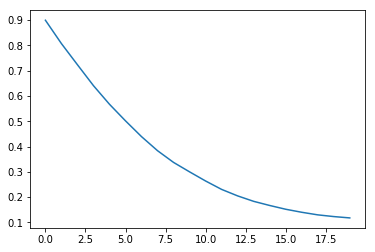

In [51]:
lag_corr = np.zeros(20)
for i in range(20):
    lag_corr[i] = np.corrcoef(r_ts[i+1:], r_ts[:-i-1])[0, 1]
plt.plot(lag_corr)

In [67]:
gan_ds_1[503]["u_res"].shape

(2000000, 8)

In [16]:
sess = K.tf.Session()
K.set_session(sess)
for epoch in np.arange(1, 20):
    sg = SubModelGAN(f"/glade/work/dgagne/exp_20_stoch/gan_generator_0702_epoch_00{epoch:02d}.h5")
    bn = sg.model.layers[-1]
    print(sess.run(bn.moving_mean))

[0.06654373]
[0.07926808]
[0.11335549]
[0.08392043]
[0.05642327]
[0.04635706]
[0.03628306]
[0.03976375]
[0.04117586]
[0.04453862]
[0.04388073]
[0.03915039]
[0.03066981]
[0.02129954]
[0.01669891]
[0.01439203]
[0.01484516]
[0.01865663]
[0.02126001]


In [22]:
sg.model.layers[7].get_weights()

[array([[-3.88251282e-02, -8.80654305e-02, -5.34439944e-02,
         -7.48020783e-02,  3.22539061e-02, -8.08196366e-02,
          3.71222794e-02, -7.07934126e-02, -5.00386134e-02,
          3.26000663e-05,  5.79780452e-02,  5.79981506e-02,
          3.59414928e-02,  5.91491424e-02, -1.16715319e-01,
          8.50356277e-03],
        [-7.45629985e-03, -1.52303427e-01, -1.21130824e-01,
         -2.34283693e-02, -8.65460113e-02,  1.48776814e-01,
         -7.69620854e-03,  1.02270067e-01, -1.17902912e-01,
          3.81549783e-02, -1.88850816e-02, -1.89300761e-01,
          1.61441118e-01,  1.18788168e-01, -4.47540209e-02,
         -5.78130707e-02],
        [-1.75923994e-03,  9.97863635e-02,  3.78877204e-03,
         -4.45600273e-03, -2.10197344e-02,  1.32425800e-01,
          3.77417635e-03,  1.70409586e-02,  1.18807025e-01,
         -8.69833748e-05,  9.57795791e-03, -1.12102798e-03,
          1.59488544e-02, -5.06954305e-02, -3.90467122e-02,
         -4.02079113e-02]], dtype=float32),
 a

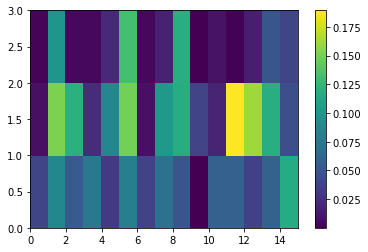

In [30]:
plt.pcolormesh(np.arange(0, 16), np.arange(0, 4), np.abs(sg.model.layers[7].get_weights()[0]))
plt.colorbar()

In [130]:
sg.model.layers[9]

In [211]:
input_vals = np.array([gan_ds[502]['x'][6000:6005, 0].values, gan_ds[502]['u'][6000:6005, 0].values]).T
print(input_vals)

[[ 0.7734047 -2.759713 ]
 [ 0.9066499 -2.5989754]
 [ 1.0400878 -2.4651544]
 [ 1.1716242 -2.1903007]
 [ 1.2996247 -1.8563511]]


In [150]:
np.expand_dims(input_vals.reshape(1, 2), axis=2).shape

(1, 2, 1)

In [213]:
norm_x, _ = normalize_data(np.expand_dims(input_vals, axis=2), sg.x_scaling_values)
print(norm_x, norm_x.shape)

[[[-0.5904691 ]
  [-1.2874838 ]]

 [[-0.56418246]
  [-1.2557733 ]]

 [[-0.53785783]
  [-1.2293732 ]]

 [[-0.51190823]
  [-1.1751499 ]]

 [[-0.48665628]
  [-1.1092682 ]]] (5, 2, 1)


In [180]:
sg.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
split1d_1 (Split1D)             (None, 1)            0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3)            0           input_1[0][0]                    
                                                                 split1d_1[0][0]                  
__________

In [219]:
rand = np.random.normal(size=(5, 17))
print(unnormalize_data(sg.pred_func([norm_x[:, :, 0], rand, 0])[0], sg.y_scaling_values))
#print(unnormalize_data(sg.model.predict([norm_x[:, :, 0], rand])[0], sg.y_scaling_values))

[[[-2.6648414]]

 [[-2.3479645]]

 [[-2.1391456]]

 [[-1.8577645]]

 [[-1.7608478]]]


In [9]:
poly = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/poly_add_climate/02000000/lorenz_forecast_02000000_00.nc")

In [10]:
truth = xr.open_dataset("/glade/work/dgagne/exp_20_stoch/lorenz_output.nc")

In [8]:
start_index = 2000000
step_values = truth["step"].values
time_values = truth["time"].values

l_start = np.where(step_values == start_index)[0][0]
l_end = l_start + 2000000
truth["lorenz_x"][l_start:l_end, 0].shape

(2000000,)

(array([ 195.,  511., 1746., 3926., 4537., 3933., 3016., 1587.,  464.,
          85.]),
 array([3.49791839, 3.80530751, 4.11269663, 4.42008575, 4.72747487,
        5.03486398, 5.3422531 , 5.64964222, 5.95703134, 6.26442046,
        6.57180957]),
 <a list of 10 Patch objects>)

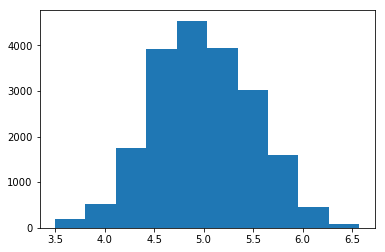

In [217]:
plt.hist(truth["lorenz_x"][l_start:l_start+20000].std(axis=1))

In [ ]:
truth_train = pd.read_csv("/glade/work/dgagne/exp_20_stoch/lorenz_combined_output.csv")

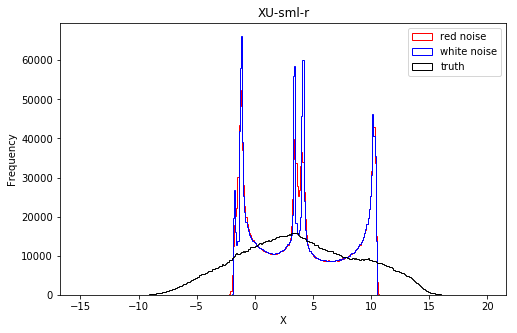

In [22]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.1)
_ = plt.hist(gan_ds[703]["x"][:, 1], bins=bins, histtype="step", color='red', label="red noise")
_ = plt.hist(gan_ds_w[703]["x"][:, 1], bins=bins, histtype="step", color='blue', label="white noise")
_ = plt.hist(truth["lorenz_x"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend()
plt.xlabel("X")
plt.ylabel("Frequency")
plt.title("XU-sml-r")
plt.savefig("gan_clim_502_old_new.png", dpi=200, bbox_inches="tight")

In [30]:
np.corrcoef(gan_ds[701].u_res[1:, 0], gan_ds[701].u_res[:-1, 0])

array([[1.        , 0.91428676],
       [0.91428676, 1.        ]])

In [226]:
train_u = np.zeros((truth_train.shape[0] // 8, 8))
for i in range(8):
    train_u[:, i] = truth_train["Ux_t+1"].values[i * train_u.shape[0]:(i+1) * train_u.shape[0]]

(array([3.000e+00, 4.300e+01, 2.100e+02, 6.980e+02, 1.819e+03, 3.602e+03,
        6.083e+03, 7.954e+03, 9.374e+03, 9.716e+03, 9.486e+03, 8.667e+03,
        7.576e+03, 6.364e+03, 4.504e+03, 2.639e+03, 1.001e+03, 2.320e+02,
        1.900e+01, 2.000e+00]),
 array([-0.61961206, -0.17475451,  0.27010305,  0.7149606 ,  1.15981816,
         1.60467571,  2.04953327,  2.49439082,  2.93924838,  3.38410594,
         3.82896349,  4.27382105,  4.7186786 ,  5.16353616,  5.60839371,
         6.05325127,  6.49810883,  6.94296638,  7.38782394,  7.83268149,
         8.27753905]),
 <a list of 20 Patch objects>)

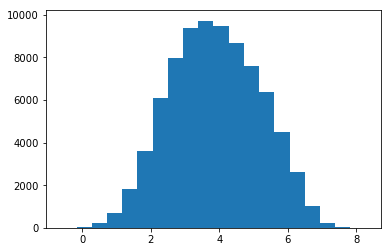

In [231]:
plt.hist(train_u.mean(axis=1), bins=20)

In [235]:
train_u.shape[0] / 1024 * 30

2343.515625

In [230]:
train_u.mean()

3.8814065966068396

In [68]:
gan_index_color = {100: (0, 0.3052, 0.5057),
                   101: (0, 0.4470, 0.7410),
                   102: (0, 0.5364, 0.8892),
                   103: (0, 0.7558, 1),
                   202: (0.2796, 0.4044, 0.1128),
                   203: (0.5126, 0.7414, 0.2068),
                   700: (0.4250, 0.1625, 0.0490),
                   701: (0.6375, 0.2438, 0.0735),
                   702: (0.8500, 0.3250, 0.0980),
                   703: (1.0, 0.3930, 0.1186),
                   802: (0.7432, 0.5552, 0.100),
                   803: (1, 0.83280, 0.150)}

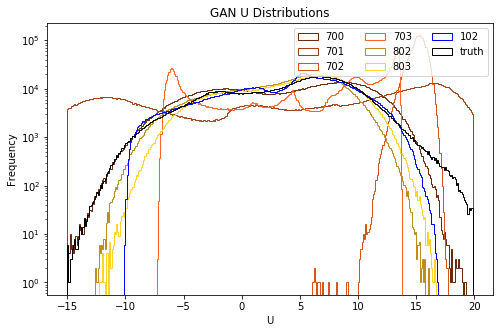

In [116]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.1)
for gi in [700, 701, 702, 703, 802, 803]:
    _ = plt.hist(gan_ds[gi]["u"][:, 0], bins=bins, histtype="step", color=gan_index_color[gi], label=str(gi))

_ = plt.hist(gan_ds[102]["u"][:, 0], bins=bins, histtype="step", color='blue', label="102")
_ = plt.hist(truth_ts["Ux_t+1"][:2000000], bins=bins, histtype="step", color='black', label="truth")
plt.gca().set_yscale("log")
#_ = plt.hist(truth["lorenz_u"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend(ncol=3)
plt.xlabel("U")
plt.ylabel("Frequency")
plt.title("GAN U Distributions")
plt.savefig("gan_clim_700_800_series_u.png", dpi=200, bbox_inches="tight")

In [48]:
truth_ts = pd.read_csv("/glade/work/dgagne/exp_20_stoch/lorenz_combined_output_test_x0.csv")
print(truth_ts.columns)

Index(['x_index', 'step', 'time', 'u_scale', 'X_t', 'Ux_t', 'Ux_t+1'], dtype='object')


In [19]:
truth_ts["step"]

0           2001810
1           2001815
2           2001820
3           2001825
4           2001830
5           2001835
6           2001840
7           2001845
8           2001850
9           2001855
10          2001860
11          2001865
12          2001870
13          2001875
14          2001880
15          2001885
16          2001890
17          2001895
18          2001900
19          2001905
20          2001910
21          2001915
22          2001920
23          2001925
24          2001930
25          2001935
26          2001940
27          2001945
28          2001950
29          2001955
             ...   
3599607    19999845
3599608    19999850
3599609    19999855
3599610    19999860
3599611    19999865
3599612    19999870
3599613    19999875
3599614    19999880
3599615    19999885
3599616    19999890
3599617    19999895
3599618    19999900
3599619    19999905
3599620    19999910
3599621    19999915
3599622    19999920
3599623    19999925
3599624    19999930
3599625    19999935


In [97]:
X_out = truth["lorenz_x"].values
truth_u = np.zeros((X_out.shape[0] - 1, X_out.shape[1]))
dt = 0.005
K = 8
F = 20
t_s = np.arange(0, X_out.shape[0] - 1)
for k in range(K):
    truth_u[:, k] = (-X_out[t_s, k - 1] * (X_out[t_s, k - 2] - X_out[t_s, (k + 1) % K]) - X_out[t_s, k] + F) - (X_out[t_s + 1, k] - X_out[t_s, k]) / dt
    print(truth_u[:, k].min(), truth_u[:, k].max())

-15.889581549280862 22.628656935820793
-17.088139993169243 22.04198001378642
-16.35433495970223 22.718584482646264
-15.578714951153989 22.849139755891855
-15.739299897806731 21.595742907289875
-16.18611109231321 23.547366896348883
-16.52806753169525 22.763056573916586
-16.246438400786765 22.02700014801608


In [88]:
X_out

<xarray.DataArray 'lorenz_x' (time: 3999600, x: 8)>
[31996800 values with dtype=float64]
Coordinates:
  * time     (time) float64 2.0 2.005 2.01 2.015 2.02 2.025 2.03 2.035 2.04 ...
  * x        (x) int64 0 1 2 3 4 5 6 7
Attributes:
    long_name:  lorenz_x
    units:      

In [87]:
truth_u.max()

160.12316115771327

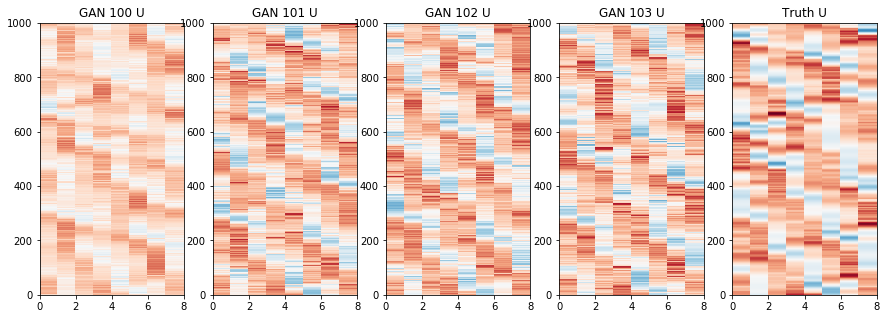

In [117]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([100, 101, 102, 103]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["u"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(truth_u[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth U")
plt.savefig("hov_gan_100_u.png", dpi=200, bbox_inches="tight")

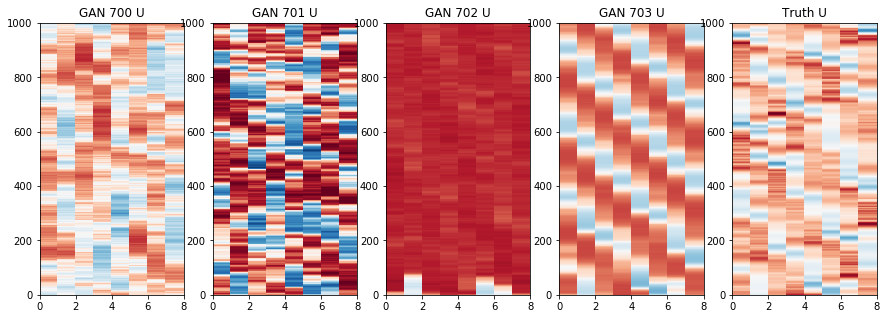

In [118]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([700, 701, 702, 703]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["u"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(truth_u[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth U")
plt.savefig("hov_gan_700_u.png", dpi=200, bbox_inches="tight")

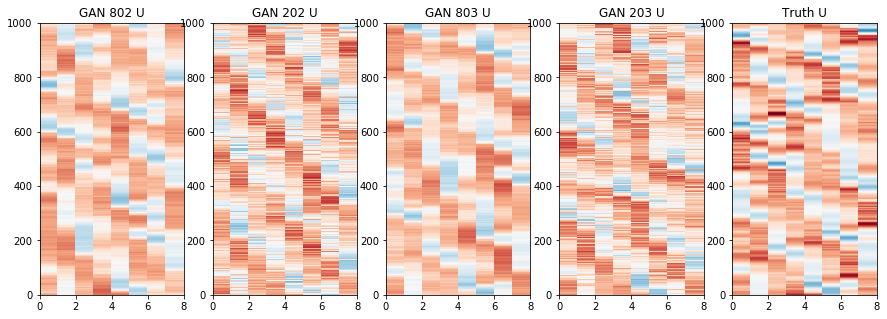

In [120]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([802, 202, 803, 203]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["u"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(truth_u[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth U")
plt.savefig("hov_gan_800_u.png", dpi=200, bbox_inches="tight")

Text(0.5,1,'Truth X')

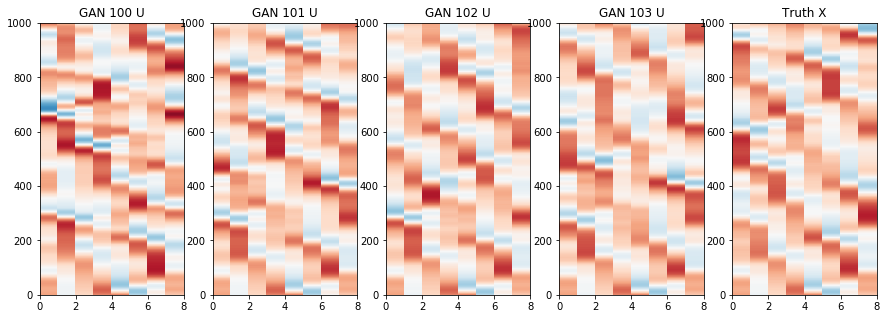

In [107]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([100, 101, 102, 103]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["x"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(X_out[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth X")

Text(0.5,1,'Truth X')

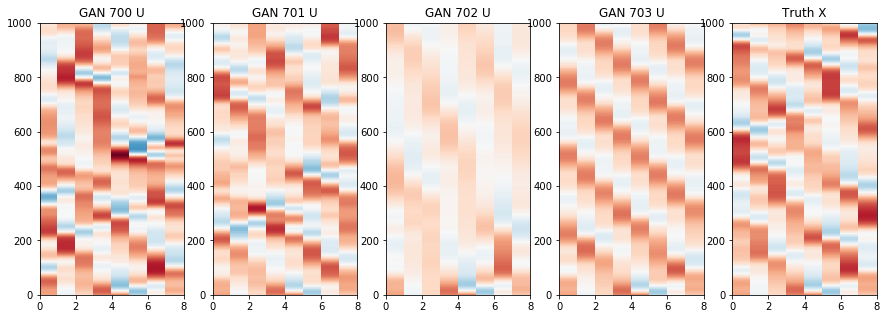

In [109]:
plt.figure(figsize=(15, 5))
for g, gi in enumerate([700, 701, 702, 703]):
    plt.subplot(1, 5, g + 1)
    plt.pcolormesh(gan_ds[gi]["x"][:1000], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("GAN {0:d} U".format(gi))
plt.subplot(1, 5, 5)
plt.pcolormesh(X_out[l_start:l_start + 1000], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth X")

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


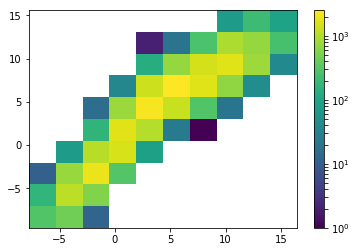

In [190]:
plt.hist2d(gan_ds_1[602]["x"][:30000, 0], gan_ds_1[602]["u"][:30000, 0], cmin=1, norm=LogNorm())
plt.colorbar()

KeyError: 801

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


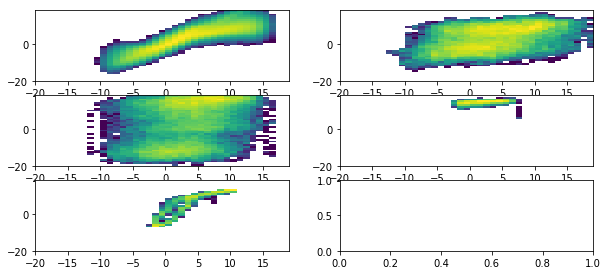

In [131]:
plt.figure(figsize=(10, 6))
plt.subplot(4, 2, 1)
h2d_truth, h2d_x_bins, h2d_y_bins, stuff = plt.hist2d(truth_ts["X_t"], truth_ts["Ux_t+1"], bins=np.arange(-20, 20), cmin=1, norm=LogNorm())
for g, gi in enumerate([700, 701, 702, 703, 801, 802, 803]):
    plt.subplot(4, 2, g + 2)
    plt.hist2d(gan_ds[gi]["x"][:50000, 0], gan_ds[gi]["u"][:50000, 0], bins=np.arange(-20, 20), cmin=1, norm=LogNorm())
    #plt.contourf(np.arange(-20.5, 20), np.arange(-20.5, 20), h2d_truth, cmap="Reds")
plt.colorbar()

In [7]:
truth_ts["Ux_t+1"][:5000].plot()
plt.plot(gan_ds[603]["u"][:5000, 0])

NameError: name 'truth_ts' is not defined

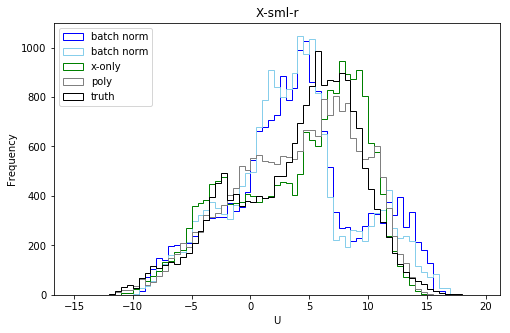

In [212]:
plt.figure(figsize=(8, 5))
bins = np.arange(-15, 20, 0.5)
#_ = plt.hist(gan_ds[702]["u"][:20000, 1], bins=bins, histtype="step", color='red', label="no batch norm")
_ = plt.hist(gan_ds_1[502]["u"][-20000:, 1], bins=bins, histtype="step", color='blue', label="batch norm")
_ = plt.hist(gan_ds_1[502]["u"][:20000, 1], bins=bins, histtype="step", color='skyblue', label="batch norm")
_ = plt.hist(gan_ds[602]["u"][-20000:, 1], bins=bins, histtype="step", color='green', label="x-only")
_ = plt.hist(poly["u"][-20000:, 1], bins=bins, histtype="step", color='gray', label="poly")
_ = plt.hist(truth_ts["Ux_t+1"][-20000:], bins=bins, histtype="step", color='black', label="truth")

#_ = plt.hist(truth["lorenz_x"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend(loc=2)
plt.xlabel("U")
plt.ylabel("Frequency")
plt.title("X-sml-r")
plt.savefig("gan_clim_u_702_old_new.png", dpi=200, bbox_inches="tight")

In [5]:
gan_index_label = {100: "XU-lrg-w",
                   101: "XU-med-w",
                   102: "XU-sml-w",
                   103: "XU-tny-w",
                   202: "X-sml-w",
                   203: "X-tny-w",
                   500: "XU-lrg-r",
                   501: "XU-med-r",
                   502: "XU-sml-r",
                   503: "XU-tny-r",
                   602: "X-sml-r",
                   603: "X-tny-r",
                   702: "XU-sml-r-n"}

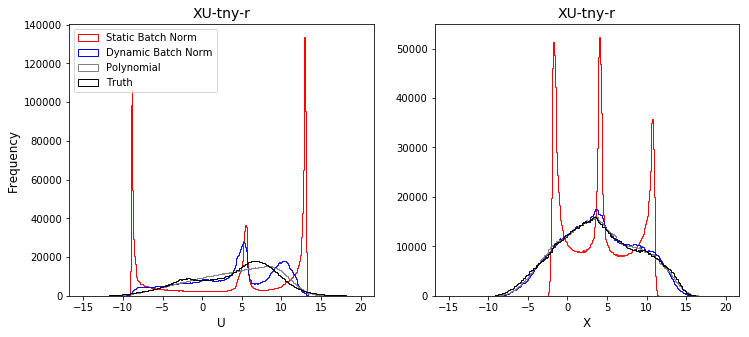

In [264]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
bins = np.arange(-15, 20, 0.1)
gan_index = 503
_ = plt.hist(gan_ds[gan_index]["u"][:, 1], bins=bins, histtype="step", color='red', label="Static Batch Norm")
_ = plt.hist(gan_ds_1[gan_index]["u"][:, 1], bins=bins, histtype="step", color='blue', label="Dynamic Batch Norm")
_ = plt.hist(poly["u"][:, 1], bins=bins, histtype="step", color='gray', label="Polynomial")
_ = plt.hist(truth_ts["Ux_t+1"][:2000000], bins=bins, histtype="step", color='black', label="Truth")

#_ = plt.hist(truth["lorenz_x"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
plt.legend(loc=2)
plt.xlabel("U", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title(gan_index_label[gan_index], fontsize=14)
plt.subplot(1, 2, 2)
bins = np.arange(-15, 20, 0.1)
_ = plt.hist(gan_ds[gan_index]["x"][:, 1], bins=bins, histtype="step", color='red', label="Static Batch Norm")
_ = plt.hist(gan_ds_1[gan_index]["x"][:, 1], bins=bins, histtype="step", color='blue', label="Dynamic Batch Norm")
_ = plt.hist(poly["x"][:, 1], bins=bins, histtype="step", color='gray', label="poly")
_ = plt.hist(truth_ts["X_t"][:2000000], bins=bins, histtype="step", color='black', label="truth")

#_ = plt.hist(truth["lorenz_x"][l_start:l_end, 0], bins=bins, histtype="step", color='k', label="truth")
#plt.legend()
plt.xlabel("X", fontsize=12)
plt.title(gan_index_label[gan_index], fontsize=14)
plt.savefig(f"gan_XU_dists_clim_{gan_index:03d}.pdf", dpi=200, bbox_inches="tight")

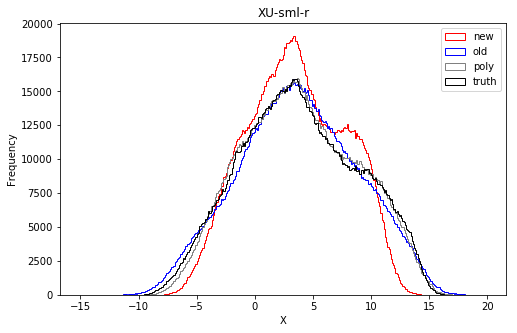

In [239]:
plt.figure(figsize=(8, 5))

plt.savefig("gan_clim_u_502_old_new.png", dpi=200, bbox_inches="tight")

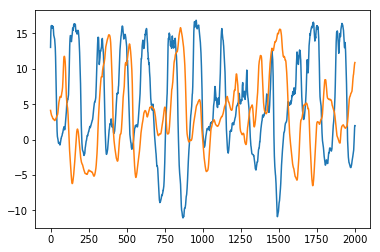

In [20]:
plt.plot(gan_ds[502]["u"][12000:14000, 1])
plt.plot(gan_ds_1[502]["u"][12000:14000, 1])

<BarContainer object of 69 artists>

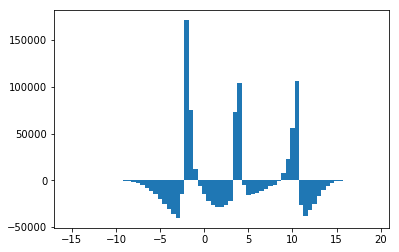

In [18]:
bins = np.arange(-15, 20, 0.5)
hist_new, _ = np.histogram(gan_ds[503]["x"][:, 0], bins=bins)
hist_old, _ = np.histogram(gan_ds_1[503]["x"][:, 0], bins=bins)
diff = hist_new - hist_old
plt.bar(bins[:-1], diff, 0.5)

In [ ]:
/glade/work/dgagne/exp_20_stoch/

In [4]:
ls /glade/work/dgagne/exp_20_stoch/*.nc

/glade/work/dgagne/exp_20_stoch/annres_config_0000_mean.nc
/glade/work/dgagne/exp_20_stoch/annres_config_0000_res.nc
/glade/work/dgagne/exp_20_stoch/lorenz_output.nc


(2000000,)

In [35]:
widths = np.arange(1, 17)
wavelets = np.zeros((len(gan_index), widths.size, gan_ds[700]["x"].shape[0]))
for g, gi in enumerate(gan_index):
    wavelets[g] = cwt(gan_ds[gi]["x"][:, 0], ricker, 2 ** widths)
wout_poly = cwt(poly["x"][:, 0], ricker, 2 ** widths)
wout_truth = cwt(truth["lorenz_x"][l_start:l_end, 0], ricker, 2 ** widths)

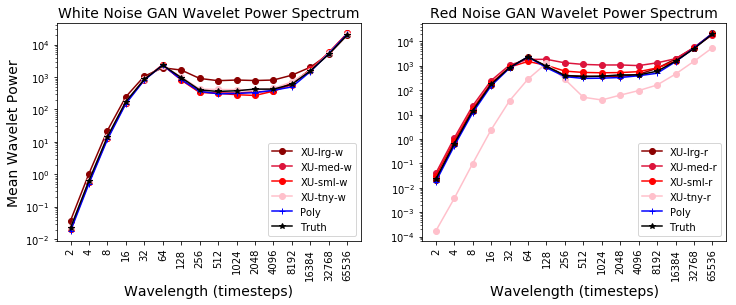

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
colors =["darkred", "crimson", "red", "pink"]
gan_configs = ["XU-lrg-w", "XU-med-w","XU-sml-w", "XU-tny-w", "XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r"]
for i in range(4):
    plt.plot(widths, np.mean(wavelets[i] ** 2, axis=1), marker='o', color=colors[i], label=gan_configs[i])
plt.plot(widths, np.mean(wout_poly ** 2, axis=1), marker='+', color="blue", label="Poly")
plt.plot(widths, np.mean(wout_truth ** 2, axis=1), marker='*', color='k', label="Truth")

plt.xticks(widths, 2 ** widths, rotation=90)
plt.legend()
plt.gca().set_yscale("log")
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.ylabel("Mean Wavelet Power", fontsize=14)
plt.title("White Noise GAN Wavelet Power Spectrum", fontsize=14)
plt.subplot(1, 2, 2)
for i in range(4, 8):
    plt.plot(widths, np.mean(wavelets[i] ** 2, axis=1), marker='o', color=colors[i-4], label=gan_configs[i])
plt.plot(widths, np.mean(wout_poly ** 2, axis=1), marker='+', color="blue", label="Poly")
plt.plot(widths, np.mean(wout_truth ** 2, axis=1), marker='*', color='k', label="Truth")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.gca().set_yscale("log")

plt.title("Red Noise GAN Wavelet Power Spectrum", fontsize=14)
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.savefig("gan_climate_wavelet_power.pdf", bbox_inches="tight")
plt.savefig("gan_climate_wavelet_power.png", dpi=200, bbox_inches="tight")

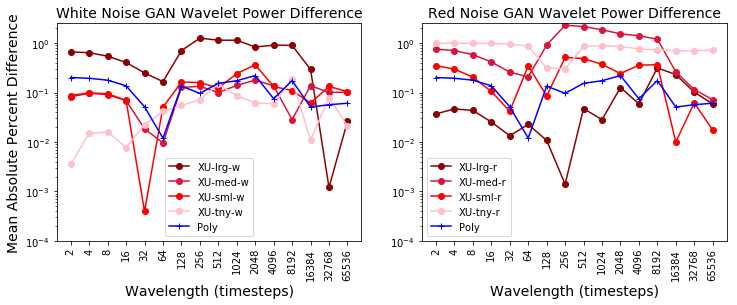

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
colors =["darkred", "crimson", "red", "pink"]
gan_configs = ["XU-lrg-w", "XU-med-w","XU-sml-w", "XU-tny-w", "XU-lrg-r", "XU-med-r", "XU-sml-r", "XU-tny-r"]
truth_power = np.mean(wout_truth ** 2, axis=1)
for i in range(4):
    plt.plot(widths, np.abs(np.mean(wavelets[i] ** 2, axis=1) - truth_power) / truth_power, marker='o', color=colors[i], label=gan_configs[i])
plt.plot(widths, np.abs(np.mean(wout_poly ** 2, axis=1) - truth_power) / truth_power, marker='+', color="blue", label="Poly")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.ylim(0.0001, 2.5)
plt.gca().set_yscale("log")
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.ylabel("Mean Absolute Percent Difference", fontsize=14)
plt.title("White Noise GAN Wavelet Power Difference", fontsize=14)
plt.subplot(1, 2, 2)
for i in range(4, 8):
    plt.plot(widths, np.abs((np.mean(wavelets[i] ** 2, axis=1) - truth_power)) / truth_power, marker='o', color=colors[i-4], label=gan_configs[i])
plt.plot(widths, np.abs(np.mean(wout_poly ** 2, axis=1) - truth_power) / truth_power, marker='+', color="blue", label="Poly")
plt.xticks(widths, 2 ** widths, rotation=90)
plt.ylim(0.0001, 2.5)
plt.gca().set_yscale("log")
plt.title("Red Noise GAN Wavelet Power Difference", fontsize=14)
plt.legend()
plt.xlabel("Wavelength (timesteps)", fontsize=14)
plt.savefig("gan_climate_wavelet_power_diff.pdf", bbox_inches="tight")
plt.savefig("gan_climate_wavelet_power_diff.png", dpi=200, bbox_inches="tight")

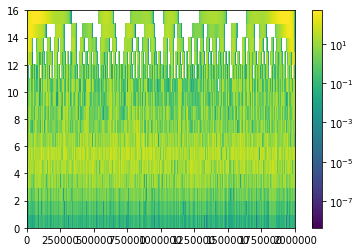

In [34]:
plt.pcolormesh(wout_truth, norm=LogNorm())
plt.colorbar()

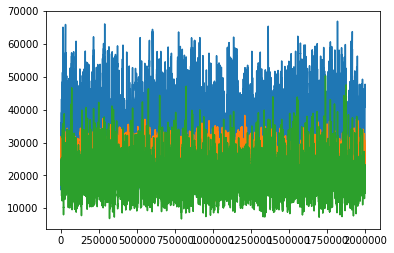

In [119]:
plt.plot(pd.Series(np.abs(wout_gan_302[5])).rolling(1000).sum())
plt.plot(pd.Series(np.abs(wout_gan_302[4])).rolling(1000).sum())
plt.plot(pd.Series(np.abs(wout_gan_302[6])).rolling(1000).sum())

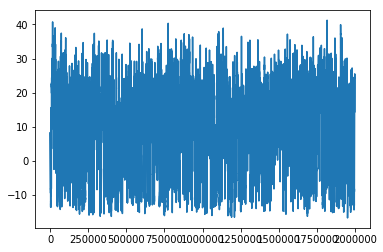

In [124]:
plt.plot(pd.Series(np.abs(wout_gan_302[5]) - np.abs(wout_gan_302[4])).rolling(1000).mean())


In [22]:
values = np.random.normal(size=1000)

In [25]:
(values * 0.1).std()

0.09929217154691021

In [27]:
vs = VarianceScaling()

In [35]:
sess = K.get_session()
init_values = sess.run(vs((1000,)))

In [38]:
init_values.std()

0.17863947

In [40]:
ru = RandomUniform(minval=0.0001, maxval=1)

In [42]:
ru_out = sess.run(ru((1000,)))

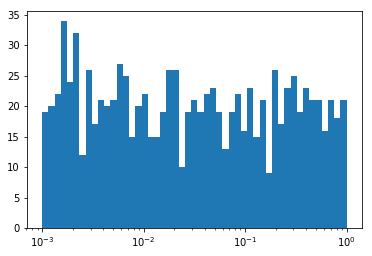

In [51]:
plt.hist(10 ** np.random.uniform(-3, 0, 1000), bins=np.logspace(-3, 0))
plt.gca().set_xscale("log")

In [60]:
class Log10RandomUniform(Initializer):
    def __init__(self, min_exp=-4, max_exp=0, seed=None):
        self.min_exp = min_exp
        self.max_exp = max_exp
        self.seed = seed
        
    def __call__(self, input_shape, dtype=None):
        return 10.0 ** K.random_uniform(input_shape, minval=self.min_exp, 
                                      maxval=self.max_exp, dtype=dtype, seed=self.seed)
    
    def get_config(self):
        return {"min_exp": self.min_exp,
                "max_exp": self.max_exp,
                "seed": self.seed}

In [61]:
l10ru = Log10RandomUniform()

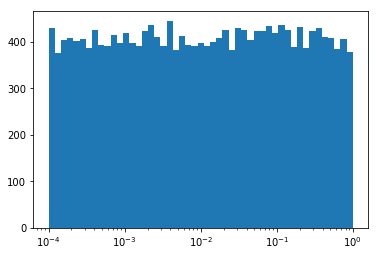

In [63]:
plt.hist(sess.run(l10ru((20000,))), bins=np.logspace(-4, 0))
plt.gca().set_xscale("log")

In [79]:
class Log10RandomUniform(Initializer):
    def __init__(self, min_exp=-4, max_exp=0, seed=None):
        self.min_exp = min_exp
        self.max_exp = max_exp
        self.seed = seed

    def __call__(self, input_shape, dtype=None):
        return 10.0 ** K.random_uniform(input_shape, minval=self.min_exp,
                                        maxval=self.max_exp, dtype=dtype, seed=self.seed)

    def get_config(self):
        return {"min_exp": self.min_exp,
                "max_exp": self.max_exp,
                "seed": self.seed}


class MinMaxConstraint(Constraint):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, w):
        return K.clip(w, self.min_val, self.max_val)

    def get_config(self):
        return {"min_val": self.min_val,
                "max_val": self.max_val}

class AutoScale(Layer):
    def __init__(self, min_exp=-4, max_exp=0, **kwargs):
        self.min_exp = min_exp
        self.max_exp = max_exp
        self.scales = None
        super(AutoScale, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.scales = self.add_weight(name="scales", shape=(input_dim, ),
                                      initializer=Log10RandomUniform(),
                                      constraint=MinMaxConstraint(10.0 ** self.min_exp,
                                                                 10.0 ** self.max_exp))

        return

    def call(self, inputs, **kwargs):
        output = inputs * self.scales
        return output

    def get_config(self):
        return {"min_exp": self.min_exp,
                "max_exp": self.max_exp,
                }

In [75]:
scale_layer = AutoScale()
scale_layer.build((1, 10))

In [125]:
cond_in = Input((2,))
rand_in = Input((2,))
rand_scale = AutoScale(min_exp=-7)(rand_in)
combined = Add()([cond_in, rand_scale])
dense_1 = Dense(16, activation="selu")(combined)
dense_2 = Dense(16, activation="selu")(dense_1)
out = Dense(1)(dense_2)
mod = Model([cond_in, rand_in], out)
mod.compile(loss="mse", optimizer="sgd")

In [126]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(truth_ts[["X_t", "Ux_t"]])
mod.fit([scaled_x, np.random.normal(size=(truth_ts.shape[0], 2))], truth_ts["Ux_t+1"] - truth_ts["Ux_t"], epochs=5, batch_size=1024)

Epoch 1/5
3599637/3599637 [==============================] - 8s 2us/step - loss: 0.1617
Epoch 2/5
3599637/3599637 [==============================] - 8s 2us/step - loss: 0.1571
Epoch 3/5
3599637/3599637 [==============================] - 8s 2us/step - loss: 0.1562
Epoch 4/5
3599637/3599637 [==============================] - 8s 2us/step - loss: 0.1556
Epoch 5/5
3599637/3599637 [==============================] - 8s 2us/step - loss: 0.1553


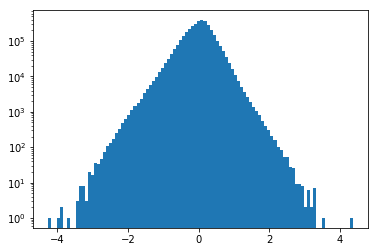

In [129]:
plt.hist(truth_ts["Ux_t+1"] - truth_ts["Ux_t"], bins=100)
plt.gca().set_yscale("log")

In [131]:
t_out = mod.predict([scaled_x, np.random.normal(size=(truth_ts.shape[0], 2))])

(-4, 4)

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


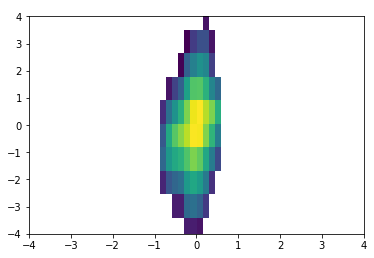

In [137]:
plt.hist2d(t_out.ravel(),truth_ts["Ux_t+1"] - truth_ts["Ux_t"], cmin=1, norm=LogNorm())
plt.xlim(-4, 4)
plt.ylim(-4, 4)

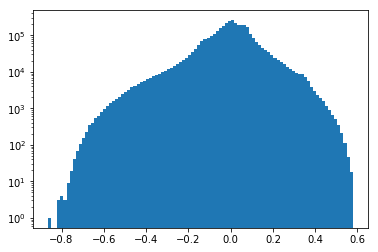

In [138]:
plt.hist(t_out.ravel(), bins=100)
plt.gca().set_yscale("log")

In [140]:
mod.layers[2].get_weights()

[array([0.00090206, 0.00035623], dtype=float32)]

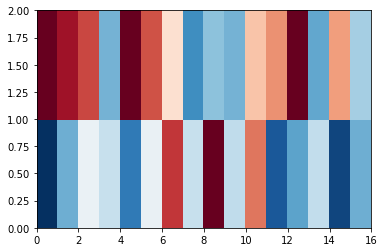

In [120]:
plt.pcolormesh(mod.layers[4].get_weights()[0], vmin=-0.5, vmax=0.5, cmap="RdBu_r")

In [123]:
np.abs(mod.layers[4].get_weights()[0]).min()

0.031570695

In [115]:
white_noise = AR1RandomUpdater()
with open("/glade/work/dgagne/exp_20_stoch/offline/ar1/ar1_random_updater_white.pkl", "wb") as wn_file:
    pickle.dump(white_noise, wn_file)

In [110]:
noise_vals = np.zeros((10000))
rs1 = np.random.RandomState(343)
wnoise_vals = np.zeros((10000))
rs2 = np.random.RandomState(343)
for i in range(1, 10000):
    noise_vals[i] = white_noise.update(noise_vals[i-1], rs=rs1)
    wnoise_vals[i] = rs2.normal() 

In [114]:
np.corrcoef(noise_vals[1:], noise_vals[:-1])

array([[1.        , 0.00518114],
       [0.00518114, 1.        ]])

In [113]:
np.corrcoef(wnoise_vals[1:], wnoise_vals[:-1])

array([[1.        , 0.00518114],
       [0.00518114, 1.        ]])